# Implémentez un modèle de scoring

- **Projet 7 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Étape 1 : Préparation du jeu de données et feature engineering


## 1.1 Compréhension du problème

### 1.1.1 Problématique

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu’un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s’appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.).

### 1.1.2 Les données

Voici [les données](https://www.kaggle.com/c/home-credit-default-risk/data) pour réaliser le
dashboard. Pour plus de simplicité, vous pouvez les télécharger à
[cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

### 1.1.1 Mission

- Sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.
- Analyser ce kernel et l’adapter aux besoins de votre mission.

Focalise sur :

1. La construction d'un **modèle de scoring** qui donnera une prédiction sur la probabilité de faillite
   d'un client de façon automatique.
   - élaboration
   - optimisation
   - comprehension (interpretabilité)
2. Construction d'un **dashboard interactif** qui montre avec transparence les décisions d’octroi de
   crédit, à destination des gestionnaires de la relation client permettant d'interpréter les
   prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation
   client.


## 1.2 Definition de l'environnement

- `local` : Développement local (avec échantillon de 50 Mo de données)
- `colab` : Google Colab
- `kaggle` : Kaggle Kernel


In [1]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = '../data/raw'
    OUT_FOLDER = '../data/out'
    IMAGE_FOLDER = '../images/nettoyage'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC7'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC7'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC7/nettoyage'


## 1.3 Fichiers de données

1. Les données en format CSV (>700Mb compactés) sont à télecharger de ce lien:

- https://www.kaggle.com/c/home-credit-default-risk/data
- Pour plus de simplicité, vous pouvez les télécharger à [cette adresse.](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

2.  Placer le fichier compacté (**.zip**) dans le **DATA_FOLDER** défini ci-dessous


### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier zip des données doit être placé dans `DATA_FOLDER` au préalable
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`


In [2]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Projet+Mise+en+prod+-+home-credit-default-risk.zip'
RAW_DATA_FILENAME = 'HomeCredit_columns_description.csv'
SAMPLE_DATA_FILENAME = 'HomeCredit_columns_description.csv'


# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 100,000 registres
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE = 10000


## 1.4 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle

```txt
# copy dans un fichier requirements.txt, puis
# !pip install -r requirements.txt
```


In [3]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# !pip install numpy pandas matplotlib seaborn scipy sklearn missingno requests


In [4]:
# import local functions
import outils_io
outils_io.install_libraries({'numpy', 'pandas', 'matplotlib',
                             'seaborn', 'requests', 'sklearn', 'imblearn'})


required modules: ['numpy', 'matplotlib', 'seaborn', 'sklearn', 'requests', 'imblearn', 'pandas']
missing modules: []


## 1.5 Import dependencies


### 1.5.1 Import des bibliothèques utilisées par ce notebook


In [5]:

from contextlib import contextmanager
import time
import gc
import os
import warnings
import platform
# suppress future warnings de pandas 1.3.0
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn


### 1.5.2 Liste des versions des bibliothèques utilisées


In [7]:
print(f'python version = {platform.python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


python version = 3.7.0
versions des bibliothèques utilisées:
platform==1.0.8; sklearn==1.0.2; seaborn==0.11.2; pandas==1.1.5; numpy==1.21.5; imblearn==0.9.0


### 1.5.3 Configuration défauts d'affichage


In [8]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 20 lignes
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab10")

RANDOM_SEED = 42


### 1.5.4 Bibliothèque personelle

On utilise un nom non standard


In [9]:
import outils_io
import outils_preprocess
import outils_stats
import outils_timed
import outils_vis

# frequently used functions
from outils_vis import to_png
from outils_timed import timer


### 1.5.5 Configuration personelle


In [10]:

# Enregistre parametres globals dans outils
outils_vis.set_option('IMAGE_FOLDER', IMAGE_FOLDER)
outils_vis.set_option('SAVE_IMAGES', True)

if ENV != 'kaggle':
    outils_io.os_make_dir(DATA_FOLDER)
    outils_io.os_make_dir(OUT_FOLDER)

outils_io.os_make_dir(IMAGE_FOLDER)


# 2. Importation des données <a name="importation"></a>


## 2.1 Configuration de l'importation des données

### 2.1.1 Choix de fichier à analyser


In [11]:
DATA_FILENAME = SAMPLE_DATA_FILENAME if ENV == 'local' else RAW_DATA_FILENAME
RAW_DATA = outils_io.os_path_join(DATA_FOLDER, DATA_FILENAME)
DATA_ZIPPED = outils_io.os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: ../data/raw/HomeCredit_columns_description.csv


In [12]:
def unzip_data_si_besoin(env=ENV):
    """procedure pour unzip sur Google Drive via Google Colab"""
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (../data/raw/HomeCredit_columns_description.csv)


## 2.2 Information sur les fichiers (taille, type, nb. registres, champs)


In [13]:

for filename in os.listdir(DATA_FOLDER):
    if filename.lower().endswith('csv'):
        filepath = f'{DATA_FOLDER}/{filename}'
        print(f'file : {filename} : size={outils_io.get_filesize(filepath)}')


file : application_test.csv : size=25.34 Mo
file : application_train.csv : size=158.44 Mo
file : bureau.csv : size=162.14 Mo
file : bureau_balance.csv : size=358.19 Mo
file : credit_card_balance.csv : size=404.91 Mo
file : HomeCredit_columns_description.csv : size=36.51 ko
file : installments_payments.csv : size=689.62 Mo
file : POS_CASH_balance.csv : size=374.51 Mo
file : previous_application.csv : size=386.21 Mo
file : sample_submission.csv : size=523.63 ko


## 2.3 Data schema

Le schema et description des données est fourni sur le lien:

- https://www.kaggle.com/competitions/home-credit-default-risk/data

<p><img title="" alt="Data" src="img/home_credit.png"></p>
<em>Original source : https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png<em>


### 2.3.1 Description des champs

- details sur <https://www.kaggle.com/competitions/home-credit-default-risk/data>


In [14]:
def field_descriptions(data_dir=DATA_FOLDER, num_rows=1000):
    df = pd.read_csv(f'{data_dir}/HomeCredit_columns_description.csv',
                     nrows=num_rows, encoding='unicode_escape')
    return df


field_descriptions().head()


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment difficulties: he/she had late payment more than X days ...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


# 3. Analyse Exploratoire

Plusieurs kernels de Kaggle ont déjà fait l'analyse exploratoire.

Ci-dessus, on présent quelques analyses rélevants à ce projet, à partir des kernels :

- <https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction>
- <https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda>

Ces analyses exploratoires sont très détaillés, donc on ne refaire leur travail ici.

Les descriptions des tables en anglais ci-dessous vient de

- <https://www.kaggle.com/competitions/home-credit-default-risk/data>


## 3.1 application_train.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).

Static data for all applications. One row represents one loan in our data sample.


In [15]:
with timer(title='Load app_train'):
    app_train = pd.read_csv(f'{DATA_FOLDER}/application_train.csv')
# Number of each type of column
app_train.info()


Load app_train - done in 3s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### Imbalanced target categories


"Distribution_of_the_Target_Column.png"


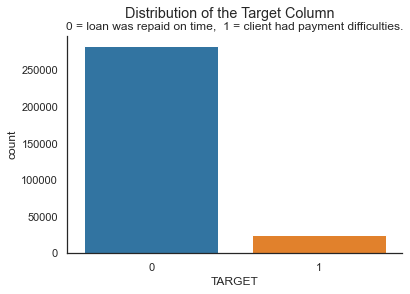

In [16]:
sns.countplot(x=app_train['TARGET'])
sns.despine()
plt.suptitle('Distribution of the Target Column')
plt.title('0 = loan was repaid on time,  1 = client had payment difficulties.')
to_png()


From this information, we see this is an [imbalanced class problem](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance.


### Valeurs manquantes


In [17]:
print(outils_stats.list_colonnes_remplis(app_train))


['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUME

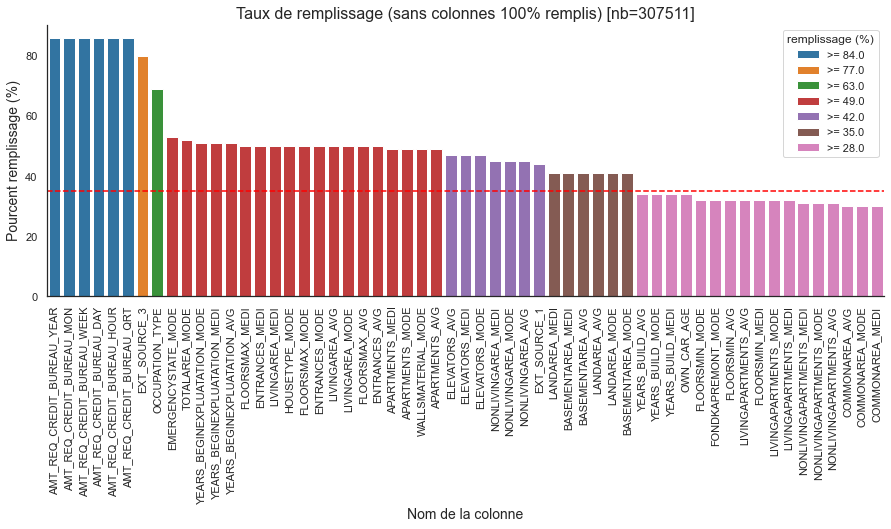

In [18]:
outils_stats.plot_bar_remplissage(app_train, figsize=(15, 5), thresh=35)


### Traitement de valeurs manquantes

Models comme XGBoost peuvent accepter des valeurs manquantes

Autres models comme RandomForest et LogisticRegression ont besoin de traitement:

- Imputation; ou
- Supprime colonnes avec haut nombre de valeurs manquantes

La suppression des colonnes avec haut nombre de valeurs manquantes est à eviter, car on ne peut pas savoir en avance si ces colonnes seront utile pour le model.

C'est particulierment dificil quand il y a très peux de target classe 1 - peut-etre 10% valeurs remplis est suffisant pour les identifier.


### Categorical variables (OHE)


In [19]:
df_categ = outils_stats.decrire_dataframe(app_train.select_dtypes('object'))
df_categ


307511 registres 16 colonnes
dtypes=object    16
dtype: int64


,% manquantes,unique,dtype,min,max,std
column,,,,,,
NAME_CONTRACT_TYPE,0.000000,2,object,NaN,NaN,NaN
CODE_GENDER,0.000000,3,object,NaN,NaN,NaN
FLAG_OWN_CAR,0.000000,2,object,NaN,NaN,NaN
FLAG_OWN_REALTY,0.000000,2,object,NaN,NaN,NaN
NAME_TYPE_SUITE,0.420148,7,object,NaN,NaN,NaN
NAME_INCOME_TYPE,0.000000,8,object,NaN,NaN,NaN
NAME_EDUCATION_TYPE,0.000000,5,object,NaN,NaN,NaN
NAME_FAMILY_STATUS,0.000000,6,object,NaN,NaN,NaN
NAME_HOUSING_TYPE,0.000000,6,object,NaN,NaN,NaN


In [20]:
print('total categories ', df_categ['unique'].sum())


total categories  140


Pour machine learning, on va encoder ces catégories avec one_hot_encoder (140 catégories)


### Defaults de paiement par categorie


"Payment_defaults_by_category.png"


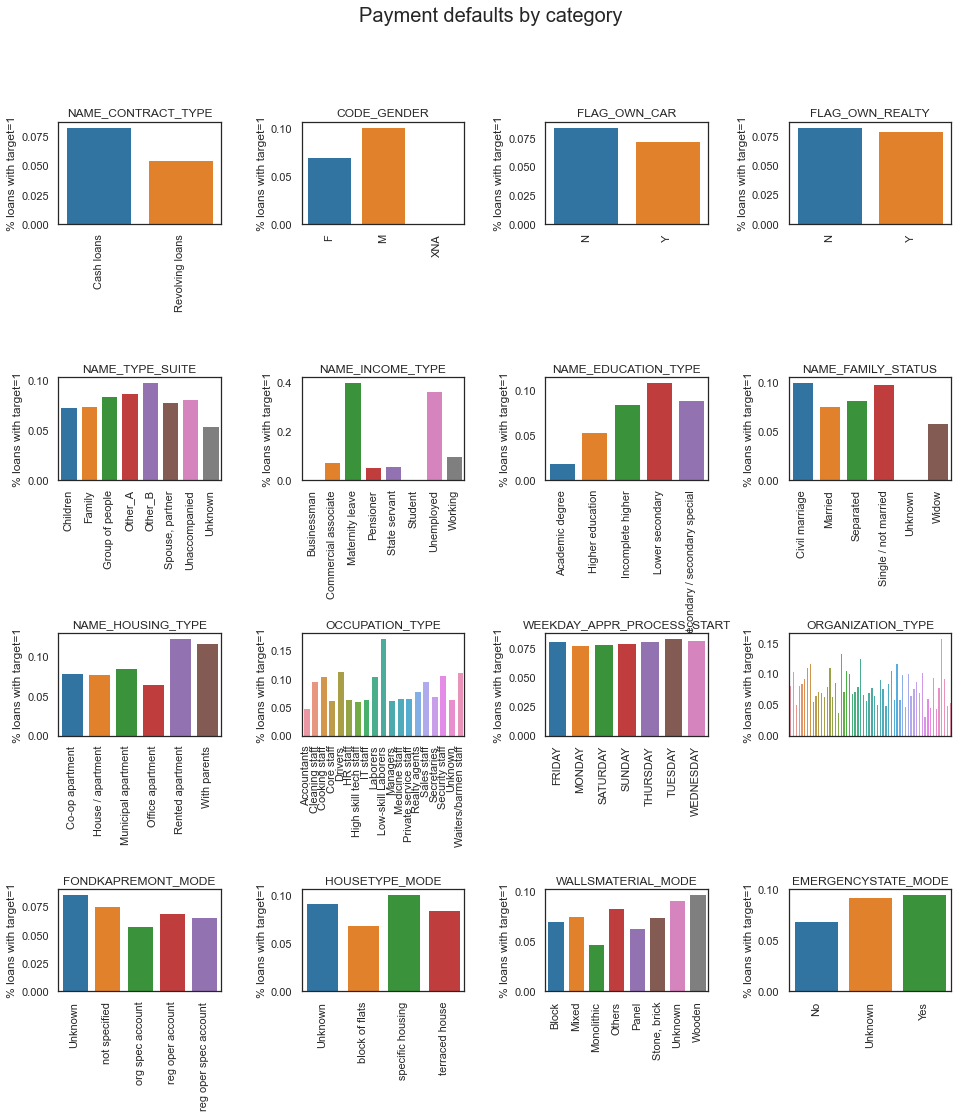

In [21]:
def plot_loan_defaults_by_categ(df):
    categorical_cols = list(df.select_dtypes(object).columns)
    n_cols = min(4, len(categorical_cols))
    n_rows = len(categorical_cols) // n_cols + \
        (len(categorical_cols) % n_cols > 0)
    fig = plt.figure(figsize=(n_cols*4, n_rows*4))

    for n, feature in enumerate(categorical_cols):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        # Calculate the percentage of target=1 per category value
        cat_perc = df[[feature, 'TARGET']].fillna(
            "Unknown").groupby([feature], as_index=False).mean()
        # cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
        cat_perc.sort_values(by=feature, inplace=True)
        sns.barplot(ax=ax, x=feature, y='TARGET',
                    order=cat_perc[feature], data=cat_perc)
        plt.xlabel('')
        plt.ylabel('% loans with target=1')
        plt.title(feature)
        if len(cat_perc) > 20:
            ax.xaxis.set_ticklabels([])
        plt.xticks(rotation=90)

    plt.subplots_adjust(hspace=1.5, wspace=0.5)


plot_loan_defaults_by_categ(app_train)
plt.subplots_adjust(hspace=1.5, wspace=0.5)
plt.suptitle('Payment defaults by category', fontsize=20)
to_png()


Du point de vue du banque, on voit que les catégories qui gerent la plus de problêmes de paiement sont :

- cash loans
- males (vs females)
- chomeurs et femmes en congé maternité
- personnes de bas niveaux de scolarité
- personnes en occupations de bas competences
- personnes en location ou vivant avec des parents


### Tables de contingence

Les pourcentages de chaque catégorie qui ont des contracts sans (0) ou avec (1) problèmes de paiement


In [22]:
(pd.crosstab(app_train['CODE_GENDER'],
 app_train['TARGET'], normalize='index', dropna=False)*100)


TARGET,0,1
CODE_GENDER,,
F,93.000672,6.999328
M,89.858080,10.141920
XNA,100.000000,0.000000


On interesse sur la pourcentage de chaque catégorie qui ont des problèmes de paiement des contrats


In [23]:
# Calculate the percentage of each category with target=1
percent_target = (app_train[['CODE_GENDER', 'TARGET']].fillna("Unknown")
                  .groupby(['CODE_GENDER'], as_index=False).mean())
percent_target['TARGET'] *= 100
percent_target


,CODE_GENDER,TARGET
0,F,6.999328
1,M,10.141920
2,XNA,0.000000


In [24]:
def plot_p_stats(df:pd.DataFrame,feature:str,label_rotation=False,horizontal_layout=True):
    """
    Plot side-by-side:  % of each category for feature, and % of loans with target=1.
    based on :https://www.kaggle.com/code/gpreda/home-credit-default-risk-extensive-eda/notebook
    """
    temp = df[feature].fillna('Unknown').value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    df1.sort_values(by=feature, inplace=True)

    # Calculate the percentage of each category with target=1
    cat_perc = df[[feature, 'TARGET']].fillna("Unknown").groupby([feature],as_index=False).mean()
    cat_perc['TARGET']*=100
    cat_perc.sort_values(by=feature, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    ax1.set_title('Count of contracts by category')
    sns.despine()

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    ax2.set_ylabel('Percent of category with target value 1 [%]')
    # plt.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_title('Percent of loans with default of payments')
    sns.despine()

    plt.suptitle(f"Contracts by category for feature '{feature}'")
    

"Contracts_by_category_for_feature_'CODE_GENDER'.png"


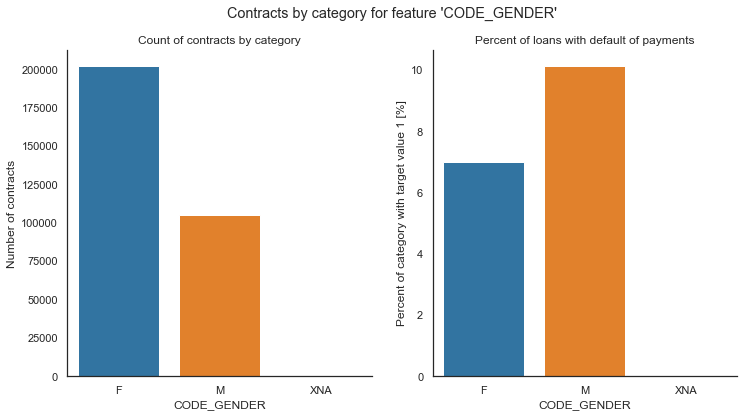

In [25]:
plot_p_stats(app_train, 'CODE_GENDER')
to_png()


#### Type de contract


"Contracts_by_category_for_feature_'NAME_CONTRACT_TYPE'.png"


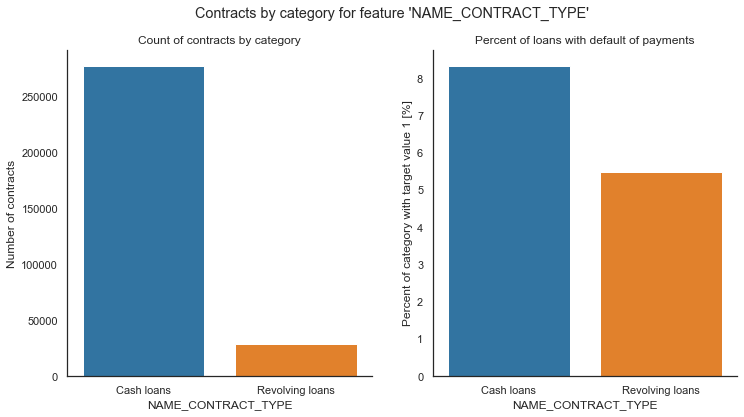

In [26]:
plot_p_stats(app_train, 'NAME_CONTRACT_TYPE')
to_png()


## Exploration des variables numériques


In [27]:
def plot_distribution(feature, color):
    """Plot distribution of one feature
    https://www.kaggle.com/code/gpreda/home-credit-default-risk-extensive-eda/notebook
    """
    plt.figure(figsize=(10, 6))
    plt.title(f'Distribution of {feature}')
    sns.distplot(application_train[feature].dropna(),
                 color=color, kde=True, bins=100)
    plt.show()


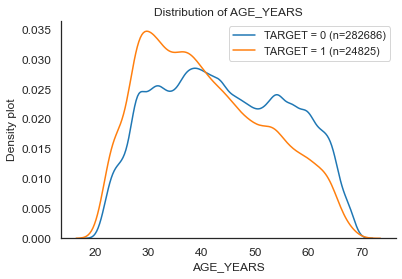

In [28]:
def plot_distribution_comp(df, feature, ax=None):
    repaid = df['TARGET'] == 0
    not_repaid = df['TARGET'] == 1
    repaid_feature = df[df['TARGET'].astype(int) == 0][feature]
    not_repaid_feature = df[df['TARGET'].astype(int) == 1][feature]
    nunique = df[feature].nunique()
    if nunique == 2:
        sns.histplot(repaid_feature,
                     label=f'TARGET = 0 (n={len(repaid_feature)})', color='#3274A1', alpha=0.5, ax=ax)
        sns.histplot(not_repaid_feature,
                     label=f'TARGET = 1 (n={len(not_repaid_feature)})', color='#E1812C', alpha=0.5, ax=ax)
        plt.ylabel('Histogram plot', fontsize=12)
    else:
        sns.kdeplot(repaid_feature,
                    label=f'TARGET = 0 (n={len(repaid_feature)})', ax=ax)
        sns.kdeplot(not_repaid_feature,
                    label=f'TARGET = 1 (n={len(not_repaid_feature)})', ax=ax)
        plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    sns.despine()


app_train['AGE_YEARS'] = - app_train['DAYS_BIRTH']/365
plot_distribution_comp(app_train, 'AGE_YEARS')


Les personnes moins de 40 ans ont plus de risque de non-paiement


### Afficher les déscriptions des champs


In [29]:
import textwrap
df_desc = field_descriptions()
feature_descript_map = dict(zip(df_desc['Row'], df_desc['Description']))


def add_text(ax, x, y, s, **kwargs):
    """Ajouter du texte à un plot"""
    s = textwrap.fill(s, 64)
    ax.text(x, y, s, verticalalignment='bottom',
            horizontalalignment='left', transform=ax.transAxes, **kwargs)


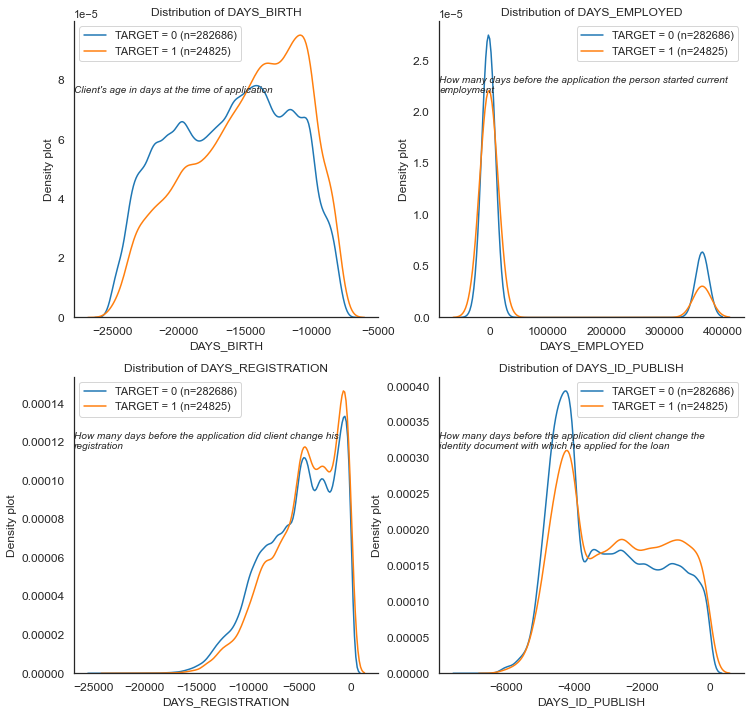

In [30]:

# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distributions(df: pd.DataFrame, features: list, nrow=2):

    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6*nrow))

    for i, feature in enumerate(features):
        ax = plt.subplot(nrow, 2, i+1)
        plot_distribution_comp(df, feature, ax)


# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distributions(df: pd.DataFrame, features: list, nrow=2, feature_description_map: dict = None):

    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6*nrow))

    for i, feature in enumerate(features):
        ax = plt.subplot(nrow, 2, i+1)
        plot_distribution_comp(df, feature, ax)
        if feature_description_map:
            description = feature_description_map.get(feature, '')
            add_text(ax, 0, 0.75, description, style='italic', fontsize=10)


plot_distributions(app_train,
                   ['DAYS_BIRTH', 'DAYS_EMPLOYED',
                       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'],
                   feature_description_map=feature_descript_map
                   )


Pour les 'DAYS_EMPLOYED' > 60 ans (> 30000 jours) , remplace par NaN


On peut répeter l'analyse exploratoire pour les > 200 variables.

Cette analyse est déja fait dans plusieurs kernels référencés dans ce notebook.

On fait le préprocessing, puis un analyse des variables les plus prometeurs


# 4. Nettoyage / Preprocessing

## 4.1 Preprocessing et Fusion des tables

Comme indiqué dans la cahier de charges, on sélectionne un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.

Les procédures de fusion des tables ci-dessous sont basés sur le pipeline de feature engineering présenté dans :

- <https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script>


### 4.1.1 One-hot encoding for categorical columns


In [31]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


### 4.1.2 Preprocess application_train.csv


In [32]:
def application_train(data_dir='data', num_rows=None, nan_as_category=False):
    # Read data
    print(f'application_train, data_dir = {data_dir}')
    df = pd.read_csv(f'{data_dir}/application_train.csv', nrows=num_rows)
    print(f'Train samples: {len(df)} rows, {len(df.columns)} columns')

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df


In [33]:
def check_columns_out(prep_fn=application_train,
                      data_dir=DATA_FOLDER, num_rows=1000, nan_as_category=False):
    """Check columns out"""
    list_cols_output = prep_fn(
        data_dir, num_rows, nan_as_category).columns.tolist()
    print(f'Number of columns output : {len(list_cols_output)}')
    print(list_cols_output)


check_columns_out(application_train)


application_train, data_dir = ../data/raw
Train samples: 1000 rows, 122 columns
Number of columns output : 233
['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVIN

### 4.1.3 Preprocess bureau.csv and bureau_balance.csv

#### bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has
`(#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows`.


In [34]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(data_dir='data', num_rows=None, nan_as_category=True):
    bureau = pd.read_csv(f'{data_dir}/bureau.csv', nrows=num_rows)
    print(
        f'Read bureau samples: {len(bureau)} rows, {len(bureau.columns)} columns')
    bb = pd.read_csv(f'{data_dir}/bureau_balance.csv', nrows=num_rows)
    print(
        f'Read bureau balance samples: {len(bb)} rows, {len(bb.columns)} columns')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [35]:
check_columns_out(bureau_and_balance)


Read bureau samples: 1000 rows, 17 columns
Read bureau balance samples: 1000 rows, 3 columns
Number of columns output : 95
['BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_VAR', 'BURO_DAYS_CREDIT_ENDDATE_MIN', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'BURO_AMT_CREDIT_SUM_MAX', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM', 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN', 'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'BURO_AMT_ANNUITY_MAX', 'BURO_AMT_ANNUITY_MEAN', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_MONTHS_BALANCE_MIN_MIN', 'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_MONTHS_BALANCE_SIZE_SUM', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'BURO_CREDIT_ACTIVE_Closed_M

### 4.1.4 Preprocess previous_applications.csv

#### previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.

There is one row for each previous application related to loans in our data sample.


In [36]:

def previous_applications(data_dir='data', num_rows=None, nan_as_category=True):
    prev = pd.read_csv(f'{data_dir}/previous_application.csv', nrows=num_rows)
    print(
        f'Read previous application samples: {len(prev)} rows, {len(prev.columns)} columns')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [37]:
check_columns_out(previous_applications)


Read previous application samples: 1000 rows, 37 columns
Number of columns output : 221
['PREV_AMT_ANNUITY_MIN', 'PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_APPLICATION_MIN', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_CREDIT_MIN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_APP_CREDIT_PERC_MIN', 'PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'PREV_APP_CREDIT_PERC_VAR', 'PREV_AMT_DOWN_PAYMENT_MIN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_GOODS_PRICE_MIN', 'PREV_AMT_GOODS_PRICE_MAX', 'PREV_AMT_GOODS_PRICE_MEAN', 'PREV_HOUR_APPR_PROCESS_START_MIN', 'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_RATE_DOWN_PAYMENT_MIN', 'PREV_RATE_DOWN_PAYMENT_MAX', 'PREV_RATE_DOWN_PAYMENT_MEAN', 'PREV_DAYS_DECISION_MIN', 'PREV_DAYS_DECISION_MAX', 'PREV_DAYS_DECISION_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN', 'PREV_NAME_CONTRACT_TYPE_C

### 4.1.5 Preprocess POS_CASH_balance.csv

#### POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has `(#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows`.


In [38]:

def pos_cash(data_dir='data', num_rows=None, nan_as_category=True):
    pos = pd.read_csv(f'{data_dir}/POS_CASH_balance.csv', nrows=num_rows)
    print(
        f'Read POS cash balance samples: {len(pos)} rows, {len(pos.columns)} columns')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


In [39]:
check_columns_out(pos_cash)


Read POS cash balance samples: 1000 rows, 8 columns
Number of columns output : 12
['POS_MONTHS_BALANCE_MAX', 'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_SK_DPD_MAX', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MAX', 'POS_SK_DPD_DEF_MEAN', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'POS_NAME_CONTRACT_STATUS_Signed_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'POS_COUNT']


### 4.1.6 Preprocess installments_payments.csv

#### installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

There is a) one row for every payment that was made plus b) one row each for missed payment.

One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


In [40]:

def installments_payments(data_dir='data', num_rows=None, nan_as_category=True):
    ins = pd.read_csv(f'{data_dir}/installments_payments.csv', nrows=num_rows)
    print(
        f'Read installments payments samples: {len(ins)} rows, {len(ins.columns)} columns')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(
        ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


In [41]:
check_columns_out(installments_payments)


Read installments payments samples: 1000 rows, 8 columns
Number of columns output : 26
['INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE', 'INSTAL_DPD_MAX', 'INSTAL_DPD_MEAN', 'INSTAL_DPD_SUM', 'INSTAL_DBD_MAX', 'INSTAL_DBD_MEAN', 'INSTAL_DBD_SUM', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM', 'INSTAL_PAYMENT_PERC_VAR', 'INSTAL_PAYMENT_DIFF_MAX', 'INSTAL_PAYMENT_DIFF_MEAN', 'INSTAL_PAYMENT_DIFF_SUM', 'INSTAL_PAYMENT_DIFF_VAR', 'INSTAL_AMT_INSTALMENT_MAX', 'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT']


### 4.1.7 Preprocess credit_card_balance.csv

#### credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has `(#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows`.


In [42]:

def credit_card_balance(data_dir='data', num_rows=None, nan_as_category=True):
    cc = pd.read_csv(f'{data_dir}/credit_card_balance.csv', nrows=num_rows)
    print(
        f'Read credit card balance samples: {len(cc)} rows, {len(cc.columns)} columns')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [43]:
check_columns_out(credit_card_balance)


Read credit card balance samples: 1000 rows, 23 columns
Number of columns output : 116
['CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN', 'CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_VAR', 'CC_AMT_BALANCE_MIN', 'CC_AMT_BALANCE_MAX', 'CC_AMT_BALANCE_MEAN', 'CC_AMT_BALANCE_SUM', 'CC_AMT_BALANCE_VAR', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MIN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM', 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MAX', 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM', 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MAX', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'CC_AMT_DRAWINGS_CURRENT_SUM', 'CC_AMT_DRAWINGS_CURRENT_VAR', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_AMT_DRAWINGS_OTHER_

## 4.2 Preprocessing (aggregation / merge) pipeline


### Run pre-processing pipeline for merging tables


In [44]:
def preprocess_pipeline(data_dir=DATA_FOLDER, num_rows=None, debug=False):
    # num_rows = 10000 if debug else None
    print(f'data_dir={data_dir}')
    df = application_train(data_dir, num_rows)
    start = time.time()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(data_dir, num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(data_dir, num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(data_dir, num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(data_dir, num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(data_dir, num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # with timer("Reduce field sizes"):
        # fonction reduce_memory a des effets bizarres sur seaborn plots - on la desactive
        # df = outils_preprocess.reduce_memory(df)

    time_taken = time.time() - start
    print(f'preprocessing completed in {time_taken:.0f} s')
    return df


### Run preprocessing ou récuperer données suite au (aggregation/fusion) pre-processing pipeline précedent

Pour éviter de répeter l'aggregation, merge de 3Go à chaque run, on charge le précedent preprocessing si rien a changé


In [45]:
savepath = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'
if os.path.exists(savepath):
    # reload preprocessed data (< 1 minute)
    print('reloading preprocessed_data (preprocess pipeline has not been modified since last edit)')
    df_data = pd.read_csv(savepath)
else:
    # preprocess pipeline takes several minutes
    df_data = preprocess_pipeline(
        data_dir=DATA_FOLDER, num_rows=None, debug=False)


print(f'df_data.shape = {df_data.shape}')


reloading preprocessed_data (preprocess pipeline has not been modified since last edit)
df_data.shape = (307507, 797)


## 4.3 Suppression des valeurs infinis

Colonnes avec des valeurs infinis empêche de mettre à l'echelle ou calculer la coefficient de correlation


In [46]:
def get_columns_with_infinite_values(df):
    res = pd.DataFrame()
    inf_cols = df.columns[np.isinf(df).any()]
    for col in inf_cols:
        inf_rows = np.isinf(df[col]).sum()
        res = res.append(
            {'colonne': col, 'inf_count': inf_rows}, ignore_index=True)
    return res


get_columns_with_infinite_values(df_data)


,colonne,inf_count
0,PREV_APP_CREDIT_PERC_MAX,1.0
1,PREV_APP_CREDIT_PERC_MEAN,1.0
2,REFUSED_APP_CREDIT_PERC_MAX,1.0
3,REFUSED_APP_CREDIT_PERC_MEAN,1.0
4,INSTAL_PAYMENT_PERC_MAX,18.0
5,INSTAL_PAYMENT_PERC_MEAN,18.0
6,INSTAL_PAYMENT_PERC_SUM,18.0


In [47]:
def get_rows_with_infinite_values(df, inf_cols=None):
    if inf_cols is None:
        inf_cols = df.columns[np.isinf(df).any()]
    inf_rows = df.index[np.isinf(df[inf_cols]).any(1)]
    return inf_rows.tolist()


print(get_rows_with_infinite_values(df_data))


[5687, 60475, 79075, 89015, 98506, 126765, 128788, 140423, 152084, 167133, 199099, 201082, 236160, 238377, 272825, 277958, 287296, 292848, 305369]


On n'a pas le temps d'investiguer pourquoi ces 19 lignes sont eronnées - on remplace les valeurs infinies avec np.nan


In [48]:

def replace_infinite_values_with_nan(df: pd.DataFrame):
    print(f'replace_infinite_values_with_nan')
    return df.replace([np.inf, -np.inf], np.nan)


df_data = replace_infinite_values_with_nan(df_data)


replace_infinite_values_with_nan


## 4.4 Filtrer variables avec une seule valeur

Les colonnes avec seulement une valeur ne sont pas discriminatoire : le coefficient de correlation sera NaN, et l'imputation pour les modèles donne une variable qui est constante.


In [49]:
def col_indexes(df: pd.DataFrame, col_names):
    """convert list of column names to list of column indexes"""
    return [df.columns.get_loc(c) for c in col_names if c in df]


def get_single_value_cols(df: pd.DataFrame):
    unique_vals = df.nunique()
    return unique_vals[unique_vals == 1].index.to_list()


single_val_cols = get_single_value_cols(df_data)
print(col_indexes(df_data, single_val_cols))


[278, 283, 299, 308, 397, 405, 408, 434, 439, 444, 454, 467, 482, 496, 502, 506, 515, 527, 533, 628, 746, 751, 761, 771, 776, 781, 791, 792, 793, 794, 795]


In [50]:
def get_non_var_columns(df: pd.DataFrame):
    std_dev = df.std()
    return std_dev[std_dev == 0].index.to_list()


non_var_cols = get_non_var_columns(df_data)
print(col_indexes(df_data, non_var_cols))


[278, 283, 299, 308, 397, 405, 408, 434, 439, 444, 454, 467, 482, 496, 502, 506, 515, 527, 533, 628, 746, 751, 761, 771, 776, 781, 791, 792, 793, 794, 795]


In [51]:
def drop_single_value_cols(df: pd.DataFrame, cols_to_drop=None):
    if cols_to_drop is None:
        cols_to_drop = get_single_value_cols(df)
    if len(cols_to_drop) > 0:
        print(f'drop_single_value_cols, nb.cols = {len(cols_to_drop)}')
        return df.drop(columns=cols_to_drop)
    return df


# df_data=drop_single_value_cols(df_data,cols_to_drop=single_val_cols)
df_data = drop_single_value_cols(df_data)


drop_single_value_cols, nb.cols = 31


## 4.3 Enregistre les données suite au (aggregation/fusion/pre-nettoyage) pre-processing pipeline

On enregistre les données après nettoyage des valeurs infinis et colonnes sans variation

Pour refaire le preprocessing complet, il suffit de supprimer les données nettoyés dans **savepath**


In [52]:
savepath = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'
if os.path.exists(savepath):
    print('not saving - preprocess pipeline has not been modified since last edit')
else:
    print('saving preprocessed_data')
    with timer(f'Save to {savepath}'):
        df_data.to_csv(savepath, index=False)

print(f'df_data.shape = {df_data.shape}')


not saving - preprocess pipeline has not been modified since last edit
df_data.shape = (307507, 766)


In [53]:
if len(df_data) > SAMPLE_SIZE:
    samplepath = f'{OUT_FOLDER}/{CLEAN_DATA_SAMPLE}'
    if not os.path.exists(samplepath):
        with timer(f'Save sample (nb = {SAMPLE_SIZE}) to {samplepath}'):
            df_data.sample(SAMPLE_SIZE).to_csv(
                samplepath, index=False)


### Taille des fichiers préprocessés


In [54]:
for filename in [CLEAN_DATA_FILENAME, CLEAN_DATA_SAMPLE]:
    filepath = f'{OUT_FOLDER}/{filename}'
    print(f'file : {filename} : size={outils_io.get_filesize(filepath)}')


file : cleaned_data_scoring.csv : size=919.9 Mo
file : cleaned_data_sample.csv : size=5.58 Mo


## Créer feature_description_map

Les nouvelles champs non pas des descriptions, car ils sont des aggregations (MAX, MIN, MEAN), ou des categories individuelles extraits des champs catégoriques.

On peut attribuer des descriptions, car le nom du champ contient le nom du champ original, parfois avec un prefix (nom du table original), ou un suffix (catégorie ou type d'aggregation)


In [55]:
def create_field_descriptions(new_names: pd.Series = None) -> pd.DataFrame:
    """Créer un nouvel liste de descriptions, basé sur la liste de new names"""
    # Sort original field names by field_name length (longest field names first)
    descr: pd.DataFrame = field_descriptions()
    descr['row_len'] = descr['Row'].str.len()
    descr = descr.sort_values(by='row_len', ascending=False)
    orig_cols: pd.Series = descr['Row']

    def get_orig_column_name(new_name: str, orig_names: pd.Series):
        """orig_names should be in order of length, with longest names first"""
        for name in orig_names:
            if name in new_name:
                return name
        return '_new_col'

    # Create mapping of new fields to original field
    # most new fields have either
    # a prefix (tablename), or a suffix (_MIN, _MAX, etc), or both
    res = pd.DataFrame()
    for new_feature in new_names:
        res = res.append(
            {'col': new_feature,
             'Row': get_orig_column_name(new_feature, orig_cols)},
            ignore_index=True)

    # join new result on original field descriptions
    df_new_descr = pd.merge(left=res, right=descr, on='Row', how='left')
    return df_new_descr


def create_field_description_map(df_new_descr: pd.DataFrame = None, new_names: pd.Series = None) -> dict:
    if df_new_descr is None:
        df_new_descr = create_field_descriptions(new_names)
    if 'col' in df_new_descr.columns:
        return dict(zip(list(df_new_descr['col']), list(df_new_descr['Description'])))
    else:
        return dict(zip(list(df_new_descr['Row']), list(df_new_descr['Description'])))


new_feature_descriptions = create_field_descriptions(list(df_data.columns))
new_feature_descriptions.tail()
# feature_description_map=create_field_description_map(df_data.columns)


,Row,col,Unnamed: 0,Table,Description,Special,row_len
1003,NAME_CONTRACT_STATUS,CC_NAME_CONTRACT_STATUS_Signed_SUM,173.0,credit_card_balance.csv,"Contract status (active signed,...) on the previous credit",NaN,20.0
1004,NAME_CONTRACT_STATUS,CC_NAME_CONTRACT_STATUS_Signed_VAR,150.0,POS_CASH_balance.csv,Contract status during the month,NaN,20.0
1005,NAME_CONTRACT_STATUS,CC_NAME_CONTRACT_STATUS_Signed_VAR,193.0,previous_application.csv,"Contract status (approved, cancelled, ...) of previous application",NaN,20.0
1006,NAME_CONTRACT_STATUS,CC_NAME_CONTRACT_STATUS_Signed_VAR,173.0,credit_card_balance.csv,"Contract status (active signed,...) on the previous credit",NaN,20.0
1007,_new_col,CC_COUNT,NaN,NaN,NaN,NaN,NaN


# 5. Vérification des données

Nous avons utilisés un preprocessing qui a donné un bon score sur LightGBM


In [56]:
print(df_data.shape)


(307507, 766)


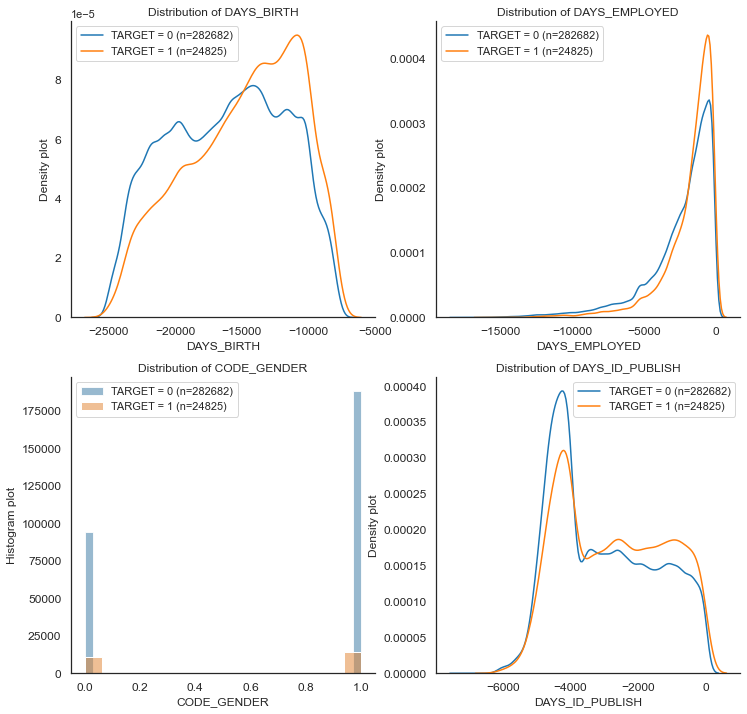

In [57]:
plot_distributions(df_data, ['DAYS_BIRTH', 'DAYS_EMPLOYED',
                             'CODE_GENDER', 'DAYS_ID_PUBLISH'])


## 5.1 Colonnes avec des valeurs NaN

Le framework [LightGBM](https://lightgbm.readthedocs.io/en/latest/) accepte les valeurs NaN, et même les utilise pour aider la classification

Autres classificateurs ne peuvent pas traité des valeurs NaNs, comme:

- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

On regarde le nombre de valeurs NaN


In [58]:
def list_nan_columns(df):
    return [i for i in df.columns if df[i].isnull().any()]


nan_colonnes = list_nan_columns(df_data)
print(f'Nombre de colonnes avec NaN values : {len(nan_colonnes)}')


Nombre de colonnes avec NaN values : 585


Presque toutes les colonnes contient les NaNs

On regarde le pourcentage remplissage


In [59]:
df_remplissage = outils_stats.decrire_dataframe(df_data)
df_remplissage.head()


307507 registres 766 colonnes
dtypes=float64    723
int64       43
dtype: int64


,% manquantes,unique,dtype,min,max,std
column,,,,,,
SK_ID_CURR,0.0,307507,int64,100002.0,456255.0,102790.132982
TARGET,0.0,2,int64,0.0,1.0,0.272420
CODE_GENDER,0.0,2,int64,0.0,1.0,0.474263
FLAG_OWN_CAR,0.0,2,int64,0.0,1.0,0.473745
FLAG_OWN_REALTY,0.0,2,int64,0.0,1.0,0.460970


In [60]:
df_remplissage['% manquantes'].describe()


count    766.000000
mean      25.686262
std       30.362631
min        0.000000
25%        0.332025
50%        5.577109
75%       67.386108
max       85.311554
Name: % manquantes, dtype: float64

- Plus que le moitié des colonnes ont moins que 6% des valeurs manquantes
- Un quart des colonnes ont plus que 67% des données manquantes

Si on décide qu'il faut un minimum de 70% de remplissage, combien de colonnes sont exclus?


In [61]:
def proportion_cols_unfilled(df, col='% manquantes', threshold=30):
    nb_cols = len(df)
    cols_unfilled = (df[col] > threshold).sum()
    proportion = cols_unfilled/nb_cols
    return proportion


prop_cols = proportion_cols_unfilled(df_remplissage)
print(f'% colonnes avec plus de 30% manquantes = {(prop_cols*100):.0f} %')


% colonnes avec plus de 30% manquantes = 31 %


On visualise sur des graphiques


"Colonnes_cumulatives_en_fonction_de_valeurs_manquantes.png"


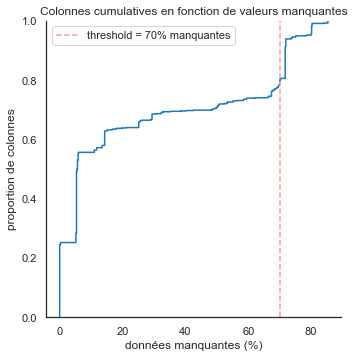

In [62]:
sns.displot(data=df_remplissage, x='% manquantes', kind='ecdf')
plt.axvline(70, label='threshold = 70% manquantes', ls='--', c='r')
plt.xlabel('données manquantes (%)')
plt.ylabel('proportion de colonnes')
plt.legend()
plt.title('Colonnes cumulatives en fonction de valeurs manquantes')
to_png()


## 5.2 Elimine colonnes avec plus de 70% données manquantes

70% manquante = 30% remplis = threshold(notnull) > 0.3


In [63]:
def drop_colonnes_trop_vides(df, threshold=0.3):
    freq = df.notnull().mean()
    print(
        f'drop_colonnes_trop_vides, threshold ={threshold}, drop colonnes : {list(df.columns[freq < threshold])}')
    return df[df.columns[freq > threshold]]


print(df_data.shape)
df_data = drop_colonnes_trop_vides(df_data)
print(df_data.shape)
df_data.notnull().mean().sort_values()[:5]


print(df_data.shape)
df_data = drop_colonnes_trop_vides(df_data)


(307507, 766)
drop_colonnes_trop_vides, threshold =0.3, drop colonnes : ['BURO_AMT_ANNUITY_MAX', 'BURO_AMT_ANNUITY_MEAN', 'BURO_MONTHS_BALANCE_MIN_MIN', 'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_STATUS_0_MEAN_MEAN', 'BURO_STATUS_1_MEAN_MEAN', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN', 'BURO_STATUS_C_MEAN_MEAN', 'BURO_STATUS_X_MEAN_MEAN', 'ACTIVE_AMT_ANNUITY_MAX', 'ACTIVE_AMT_ANNUITY_MEAN', 'ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_MAX_MAX', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'CLOSED_AMT_ANNUITY_MAX', 'CLOSED_AMT_ANNUITY_MEAN', 'CLOSED_MONTHS_BALANCE_MIN_MIN', 'CLOSED_MONTHS_BALANCE_MAX_MAX', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'REFUSED_AMT_ANNUITY_MIN', 'REFUSED_AMT_ANNUITY_MAX', 'REFUSED_AMT_ANNUITY_MEAN', 'REFUSED_APP_CREDIT_PERC_VAR', 'REFUSED_AMT_DOWN_PAYMENT_MIN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN', 'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REFUSED_RATE_DO

In [64]:
print(df_data.shape)
df_data.notnull().mean().sort_values()[:5]


(307507, 602)


COMMONAREA_MEDI                 0.301278
COMMONAREA_AVG                  0.301278
COMMONAREA_MODE                 0.301278
REFUSED_AMT_GOODS_PRICE_MEAN    0.303177
REFUSED_AMT_GOODS_PRICE_MAX     0.303177
dtype: float64

Visualise remplissage aprés suppression de colonnes plus de 70% vides


307507 registres 602 colonnes
dtypes=float64    559
int64       43
dtype: int64
"Colonnes_cumulatives_en_fonction_de_valeurs_manquantes_(après_suppression_lt.30_%_remplis).png"


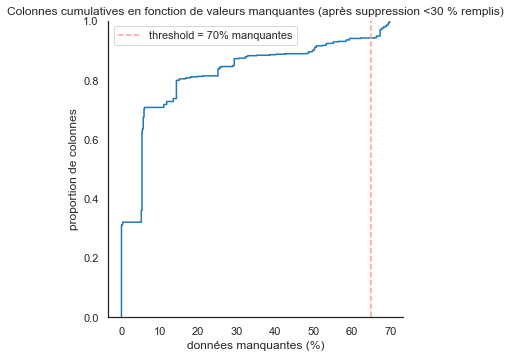

In [65]:
df_remplissage = outils_stats.decrire_dataframe(df_data)
sns.displot(data=df_remplissage, x='% manquantes', kind='ecdf')
plt.axvline(65, label='threshold = 70% manquantes', ls='--', c='r')
plt.xlabel('données manquantes (%)')
plt.ylabel('proportion de colonnes')
plt.legend()
plt.title('Colonnes cumulatives en fonction de valeurs manquantes (après suppression <30 % remplis)')
to_png()


# 6. Feature selection

On considere feature sélection comme partie du modélisation.

Pourtant, on a toujours environ 600 colonnes de données, qui va ralenti beaucoup la modélisation.

La plupart seront insignifiant en importance pour la modèle.

Donc, on va sélectionner les 100 'best' features dans ce notebook de nettoyage, puis laisser la modélisation determiner les importances rélatives de ces 100 features.


### Stratégies pour pré-sélectionner les features les plus importantes

On a plusieurs stratégies pour réduire le nombre de variables :

**Filter**

1. Pearson Correlation
2. Select KBest(f_classif) - fast(anova)
3. Select KBest(mutual_info_classif) - nearest neighbours
4. Select KBest(Chi-2) - (exige filled, non-negative)
5. Variance Influence Factor < 5

**Wrapper**

1. RFE (sur Logistic Regression par exemple)

**Embedded**

1. LightGBM
2. Random Forest
3. Logistics Regression L1

La réference ci-dessous donne un exemple de comment mettre en place 6 de ces méthodes pour les champs d'application_train

### Référence

- <https://www.kaggle.com/code/sz8416/6-ways-for-feature-selection/>
- [Laborda, Juan & Ryoo, Seyong. (2021). Feature Selection in a Credit Scoring Model (Mathematics ISSN 2227-7390). 9 (7). 10.3390/math9070746.](https://www.researchgate.net/publication/350525439_Feature_Selection_in_a_Credit_Scoring_Model_Mathematics_ISSN_2227-7390)


Pour simplicité, on utilise une ensemble de méthodes pour sélectionner les 100 features les plus importants

On va comparer les feature importances (LGBM Classifier)
(a) sur les données nettoyés
(b) sur les données avec undersampling


### 6.1.1 Rename fields

LightGBMClassifier ne support pas certain caracteres dans le nom des champs.

- <https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same>

On standardise les noms des colonnes pour résoudre ce problème.


In [66]:
import re
# https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same


def clean_name(old_name):
    old_name = old_name.replace(' ', '_')
    old_name = re.sub('[^A-Za-z0-9_]+', '', old_name)
    old_name = old_name.replace('__', '_')
    return old_name


# test avec nom temoin
clean_name('ages - (93_years)')


'ages_93_years'

In [67]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    cols_orig = df.columns
    cols_new = [clean_name(col) for col in cols_orig]
    df = df.copy()
    df.columns = cols_new
    cols_new = df.columns
    cols_diff = (cols_orig != cols_new)
    if cols_diff.sum() > 0:
        cols = pd.concat([pd.Series(cols_orig), pd.Series(cols_new)], axis=1)
        cols = cols[cols_diff]
        cols.columns = ['orig', 'new']
        print(cols)
    return df


df_data = df_data.pipe(clean_column_names)


                                                          orig  \
109                              NAME_CONTRACT_TYPE_Cash loans   
110                         NAME_CONTRACT_TYPE_Revolving loans   
113                            NAME_TYPE_SUITE_Group of people   
116                            NAME_TYPE_SUITE_Spouse, partner   
119                      NAME_INCOME_TYPE_Commercial associate   
..                                                         ...   
506  PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN   
507      PREV_PRODUCT_COMBINATION_POS other with interest_MEAN   
508  PREV_PRODUCT_COMBINATION_POS others without interest_MEAN   
567               POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN   
572        POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN   

                                                           new  
109                              NAME_CONTRACT_TYPE_Cash_loans  
110                         NAME_CONTRACT_TYPE_Revolving_loans  
113         

### 6.1.2 Create X (fields), y (target)


In [68]:

def create_X_y(df: pd.DataFrame, drop_cols=None):
    target = df['TARGET'].copy()
    if not drop_cols is None:
        df = df.drop(columns=drop_cols)
    fields = df.drop(columns=['TARGET'])
    return fields, target


X, y = create_X_y(df_data)
get_non_var_columns(X)


[]

### 6.1.3 Random Undersample

Les données sont 92% de target==0 (très désequilibré)

On fait un simple 'undersample' aléatoire pour avoir la même nombre de target==0 et target ==1 pendant feature selection.


In [69]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(type(X), X.shape)
print(type(X_resampled), X_resampled.shape)
print(type(y), y.shape)
print(type(y_resampled), y_resampled.shape)

print(f'\ny value counts :')
print(y.value_counts(normalize=True)*100)
print(f'\ny_resampled value counts :')
print(y_resampled.value_counts(normalize=True)*100)


<class 'pandas.core.frame.DataFrame'> (307507, 601)
<class 'pandas.core.frame.DataFrame'> (49650, 601)
<class 'pandas.core.series.Series'> (307507,)
<class 'pandas.core.series.Series'> (49650,)

y value counts :
0    91.927013
1     8.072987
Name: TARGET, dtype: float64

y_resampled value counts :
1    50.0
0    50.0
Name: TARGET, dtype: float64


Vérifier que les colonnes des données resampled ont toujours des variations de données


In [70]:
non_var_cols = get_non_var_columns(X_resampled)
non_var_cols


['FLAG_MOBIL',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_FAMILY_STATUS_Unknown',
 'BURO_CREDIT_CURRENCY_currency_4_MEAN',
 'BURO_CREDIT_TYPE_Interbank_credit_MEAN',
 'BURO_CREDIT_TYPE_Loan_for_purchase_of_shares_margin_lending_MEAN',
 'BURO_CREDIT_TYPE_Mobile_operator_loan_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
 'POS_NAME_CONTRACT_STATUS_XNA_MEAN']

Drop colonnes qui ne varie pas après réequilibrage de targets


In [71]:
X_resampled = drop_single_value_cols(X_resampled)
X = X.drop(columns=non_var_cols)
df_data = df_data.drop(columns=non_var_cols)


drop_single_value_cols, nb.cols = 11


### Fill missing values

La plupart des modèles ont besoin des données sans NaN

Pour simplicité, comme beaucoup des distributions sont très assymetrique, on remplis les valeurs NaN avec la médiane.

Après fit du modèle, on peut re'évaluer si on peut améliorer les prédictions

- avec KNNImputer pour les features les plus importantes (par exemple),

mais c'est plus dificil a justifier ce type d'imputation au client.


In [72]:
from sklearn.impute import SimpleImputer


def fill_missing_values(df, strategy='median'):
    """
    impute missing values, returning a dataframe
    Sklearn's SimpleImputer does not currently implement get_features_out, 
    so cannot easily be used in a pipeline 
    (otherwise we loose capacity to get feature importances from final classifier)
    Impute missing values before pipeline
    """
    imputer = SimpleImputer(strategy='median')
    return pd.DataFrame(imputer.fit_transform(df), index=df.index, columns=df.columns)


X_filled = fill_missing_values(X_resampled)


In [73]:
get_non_var_columns(X_filled)


[]

Mettre les valeurs de tous les colonnes au même échelle


In [74]:
from sklearn import preprocessing


def scale_dataframe(df: pd.DataFrame, scaler=None) -> pd.DataFrame:
    if scaler is None:
        scaler = preprocessing.StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)


X_scaled = scale_dataframe(X_filled, scaler=preprocessing.MinMaxScaler())


## Ensemble feature selection

On peut préselectionner le nombre de features des données à fournir au modélisation.

Si MAX_FEATURES = 600, tous les features seront utilisés (trop de bruit)

Dans un premier temps, on fix au 100 features sélectionnés les plus souvent par un ensemble de méthodes de feature selection.


In [75]:
MAX_FEATURES = 100


### Filter

documentation for SelectKBest: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

### 1.1 Pearson Correlation

Les filtres basés sur corrélation suppose un rélation linéaire entre les variables.

Comme il y a seulement 2 classes de cible (0 ou 1), on peut considerer le cible comme une variable ordinale, donc on peut utiliser la correlation avec la cible comme un indicateur d'importance du feature.

Note

- Normalization: no
- Impute missing values: yes


In [76]:
def cor_selector(X_, y_):
    cor_list = []
    # calculate the correlation with y for each feature
    feature_names = X.columns.tolist()
    for feature in feature_names:
        cor = np.corrcoef(X_[feature], y_)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X_.iloc[:, np.argsort(
        np.abs(cor_list))[-MAX_FEATURES:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [
        True if feature in cor_feature else False for feature in feature_names]
    return cor_support, cor_feature


with timer('Correlation'):
    cor_support, cor_feature = cor_selector(X_filled, y_resampled)
print(str(len(cor_feature)), 'selected features')


Correlation - done in 1s
100 selected features


### 1.2 Chi-2

Note

- Normalization: MinMaxScaler (values should be bigger than 0)
- Impute missing values: yes


In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

chi_selector = SelectKBest(chi2, k=MAX_FEATURES)
with timer('Chi_selector'):
    chi_selector.fit(X_scaled, y_resampled)
chi_support = chi_selector.get_support()
chi_feature = X_scaled.loc[:, chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')


Chi_selector - done in 0s
100 selected features


### 2. Wrapper

documentation for RFE: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Note:

- Normalization: depend on the used model; yes for LR
- Impute missing values: depend on the used model; yes for LR


In [78]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeClassifier

# Utilise un autre Classifier pour meilleur résultats
# On utilise RidgeClassifier ici pour vitesse, car RFE peut être très chronophage
rfe_selector = RFE(estimator=RidgeClassifier(alpha=2000),
                   n_features_to_select=MAX_FEATURES,
                   step=10, verbose=False)
with timer('Recursive Feature Elimination (RidgeClassifier)'):
    rfe_selector.fit(X_scaled, y_resampled)
rfe_support = rfe_selector.get_support()
rfe_feature = X_scaled.loc[:, rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')


Recursive Feature Elimination (RidgeClassifier) - done in 30s
100 selected features


### 3. Embedded

documentation for SelectFromModel: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

### 3.1 Logistics Regression L1

Note

- Normalization: Yes
- Impute missing values: Yes


In [79]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embedded_lr_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), max_features=MAX_FEATURES)
with timer('LogisticRegression'):
    embedded_lr_selector.fit(X_scaled, y_resampled)
embedded_lr_support = embedded_lr_selector.get_support()
embedded_lr_feature = X_scaled.loc[:, embedded_lr_support].columns.tolist()
print(str(len(embedded_lr_feature)), 'selected features')


LogisticRegression - done in 154s
100 selected features


### 3.2 Random Forest

Note

- Normalization: No
- Impute missing values: Yes


In [80]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embedded_rf_selector = SelectFromModel(RandomForestClassifier(
    n_estimators=100), max_features=MAX_FEATURES)
with timer('Random Forest'):
    embedded_rf_selector.fit(X_filled, y_resampled)
embedded_rf_support = embedded_rf_selector.get_support()
embedded_rf_feature = X_filled.loc[:, embedded_rf_support].columns.tolist()
print(str(len(embedded_rf_feature)), 'selected features')


Random Forest - done in 53s
100 selected features


### 3.3 LightGBM

Note

- Normalization: No
- Impute missing values: No


In [81]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                      reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embedded_lgb_selector = SelectFromModel(lgbc, max_features=MAX_FEATURES)
with timer('LightGBM'):
    embedded_lgb_selector.fit(X_resampled, y_resampled)
embedded_lgb_support = embedded_lgb_selector.get_support()
embedded_lgb_feature = X_resampled.loc[:, embedded_lgb_support].columns.tolist()
print(str(len(embedded_lgb_feature)), 'selected features')


LightGBM - done in 18s
100 selected features


## Comparaison des 100 'best' features selectionnés


In [82]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_names = X.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature': feature_names, 'Pearson': cor_support, 'Chi-2': chi_support, 'RFE': rfe_support, 'Logistics': embedded_lr_support,
                                    'Random Forest': embedded_rf_support, 'LightGBM': embedded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(
    ['Total', 'Feature'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,EXT_SOURCE_3,True,True,True,True,True,True,6
2,EXT_SOURCE_2,True,True,True,True,True,True,6
3,EXT_SOURCE_1,True,True,True,True,True,True,6
4,PREV_DAYS_DECISION_MIN,True,True,True,False,True,True,5
5,PREV_AMT_ANNUITY_MEAN,True,False,True,True,True,True,5
6,DAYS_ID_PUBLISH,True,True,True,False,True,True,5
7,DAYS_EMPLOYED_PERC,True,True,True,False,True,True,5
8,DAYS_EMPLOYED,True,False,True,True,True,True,5
9,DAYS_BIRTH,True,True,True,False,True,True,5
10,CLOSED_DAYS_CREDIT_MIN,True,True,True,False,True,True,5


## Drop colonnes qui ne sont pas dans les 100 'best' features


In [83]:
best_features = list(feature_selection_df['Feature'])[:MAX_FEATURES]
if not 'SK_ID_CURR' in best_features:
    best_features = ['SK_ID_CURR', *best_features]
new_columns = [*best_features, 'TARGET']


In [103]:
df_data = df_data[new_columns]

# on selectionne les best features pour un analyse des features seléctionnés
X = X[best_features]
X_resampled = X_resampled[best_features]
X_filled = X_filled[best_features]
X_scaled = X_scaled[best_features]


In [104]:
print (df_data.shape)
print (X.shape)
print (X_resampled.shape)
print (X_filled.shape)
print (X_scaled.shape)

(307507, 101)
(307507, 100)
(49650, 100)
(49650, 100)
(49650, 100)


## Enregistre les best features nettoyés

In [85]:
best_features_path = f'{OUT_FOLDER}/{CLEAN_DATA_FEATURES}'
with timer(f'Save to {best_features_path}'):
    df_data.to_csv(best_features_path, index=False)


Save to ../data/out/cleaned_data_features.csv - done in 34s


In [86]:
if len(df_data) > SAMPLE_SIZE:
    samplepath = f'{OUT_FOLDER}/{CLEAN_DATA_SAMPLE}'
    with timer(f'Save sample (nb = {SAMPLE_SIZE}) to {samplepath}'):
        df_data.sample(SAMPLE_SIZE).to_csv(
            samplepath, index=False)


Save sample (nb = 10000) to ../data/out/cleaned_data_sample.csv - done in 1s


In [87]:
print (df_data.shape)

(307507, 101)


### Taille des fichiers des best features

In [88]:
for filename in [CLEAN_DATA_FEATURES, CLEAN_DATA_SAMPLE]:
    filepath = f'{OUT_FOLDER}/{filename}'
    print(f'file : {filename} : size={outils_io.get_filesize(filepath)}')

file : cleaned_data_features.csv : size=170.37 Mo
file : cleaned_data_sample.csv : size=5.54 Mo


# Feature importances

## Effet de sampling strategy

Pour la modélisation, on analyse si le sampling strategy  change l'importance des principales features.

Pour explorer l'effet, on utilise un Light GBM classifier avec les hyperparametres d'un kernel optimisé pour ce jeu de données.



In [112]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
from lightgbm import LGBMClassifier, log_evaluation, early_stopping

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code


def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    # train_df= df[df['TARGET'].notnull()]
    # test_df = df[df['TARGET'].isnull()]
    train_df, test_df = train_test_split(df, test_size=0.25)
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(
        train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(
            n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in [
        'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            # callbacks=[log_evaluation(), early_stopping(stopping_rounds=200)],
            # callbacks=[log_evaluation(200)],
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc', verbose=200, early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(
            valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[
            :, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' %
              (n_fold + 1, metrics.roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    full_auc_score = metrics.roc_auc_score(train_df['TARGET'], oof_preds)
    print(f'Full AUC score {full_auc_score:.6f}')
    # Write submission file and plot feature importance
    if not debug:
        # enregistre predictions au cas ou on veut les analyser
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(f'{OUT_FOLDER}/lgbm_test_out.csv', index=False)
    display_importances(feature_importance_df, full_auc_score)
    return feature_importance_df

# Display/plot feature importance


def display_importances(feature_importance_df_, full_auc_score):
    cols = feature_importance_df_[["feature", "importance"]].groupby(
        "feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(
        cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(
        by="importance", ascending=False))
    plt.suptitle('LightGBM Features (avg over folds)')
    plt.title(f'Full AUC score {full_auc_score:.3f}')
    plt.tight_layout()


#### LightGBM sans resampling


Starting LightGBM. Train shape: (230630, 101), test shape: (76877, 101)


c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.810074	training's binary_logloss: 0.230784	valid_1's auc: 0.770866	valid_1's binary_logloss: 0.242993
[400]	training's auc: 0.838175	training's binary_logloss: 0.218912	valid_1's auc: 0.777668	valid_1's binary_logloss: 0.240218
[600]	training's auc: 0.857682	training's binary_logloss: 0.210823	valid_1's auc: 0.779817	valid_1's binary_logloss: 0.239483
[800]	training's auc: 0.872904	training's binary_logloss: 0.20417	valid_1's auc: 0.780349	valid_1's binary_logloss: 0.239316
[1000]	training's auc: 0.885227	training's binary_logloss: 0.198558	valid_1's auc: 0.780454	valid_1's binary_logloss: 0.239315
Fold  1 AUC : 0.780477


c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.812065	training's binary_logloss: 0.230221	valid_1's auc: 0.767604	valid_1's binary_logloss: 0.243458
[400]	training's auc: 0.839533	training's binary_logloss: 0.218412	valid_1's auc: 0.775522	valid_1's binary_logloss: 0.240663
[600]	training's auc: 0.858533	training's binary_logloss: 0.210424	valid_1's auc: 0.777419	valid_1's binary_logloss: 0.240075
[800]	training's auc: 0.874407	training's binary_logloss: 0.203501	valid_1's auc: 0.777684	valid_1's binary_logloss: 0.24001
[1000]	training's auc: 0.888368	training's binary_logloss: 0.197096	valid_1's auc: 0.777599	valid_1's binary_logloss: 0.240082
Fold  2 AUC : 0.777709
Full AUC score 0.779095
Run LightGBM with kfold - done in 183s
"LightGBM_Feature_Importance_(no_sampling,_avg_over_2_folds).png"


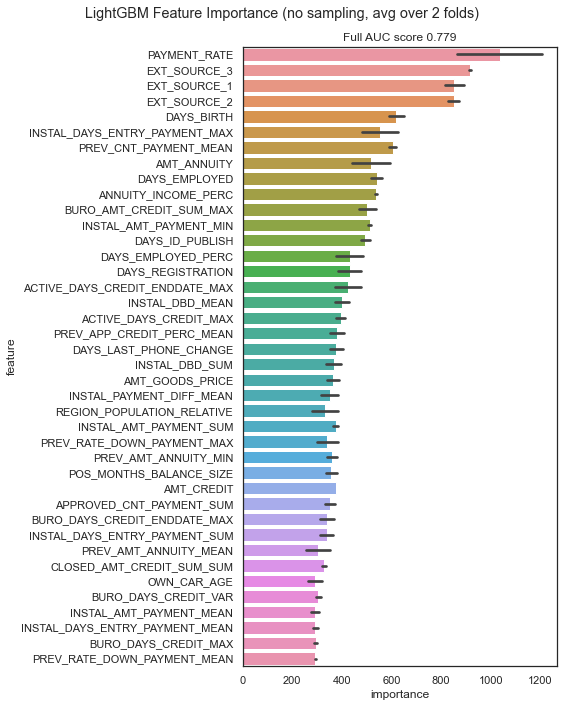

In [113]:

with timer("Run LightGBM with kfold"):
    feat_importance_lgbm1 = kfold_lightgbm(pd.concat(
        [X, y], axis=1), num_folds=2, stratified=True, debug=False)

plt.suptitle('LightGBM Feature Importance (no sampling, avg over 2 folds)')
to_png()


#### LightGBM avec undersampling


Starting LightGBM. Train shape: (37237, 101), test shape: (12413, 101)


c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.836214	training's binary_logloss: 0.52163	valid_1's auc: 0.767929	valid_1's binary_logloss: 0.578494
[400]	training's auc: 0.87229	training's binary_logloss: 0.475086	valid_1's auc: 0.773723	valid_1's binary_logloss: 0.571191
[600]	training's auc: 0.89897	training's binary_logloss: 0.441691	valid_1's auc: 0.775119	valid_1's binary_logloss: 0.569916
Fold  1 AUC : 0.775143


c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.841464	training's binary_logloss: 0.516966	valid_1's auc: 0.765904	valid_1's binary_logloss: 0.579785
[400]	training's auc: 0.877085	training's binary_logloss: 0.469476	valid_1's auc: 0.770716	valid_1's binary_logloss: 0.573801
[600]	training's auc: 0.89986	training's binary_logloss: 0.439356	valid_1's auc: 0.77109	valid_1's binary_logloss: 0.573835
Fold  2 AUC : 0.771261
Full AUC score 0.773210
Run LightGBM with kfold - done in 37s
"LightGBM_Feature_Importance_(undersampling,_avg_over_2_folds).png"


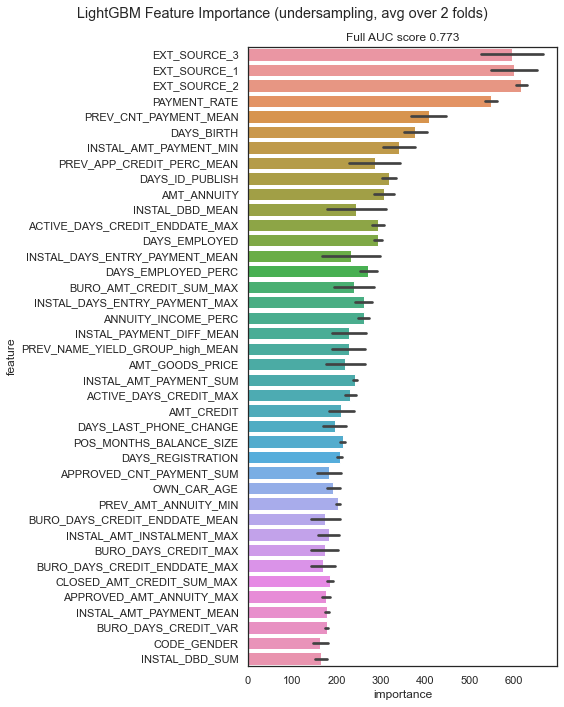

In [114]:
with timer("Run LightGBM with kfold"):
    feat_importance_lgbm2 = kfold_lightgbm(pd.concat(
        [X_resampled, y_resampled], axis=1), num_folds=2, stratified=True, debug=False)

plt.suptitle('LightGBM Feature Importance (undersampling, avg over 2 folds)')
to_png()


In [115]:
print(feat_importance_lgbm2.shape)
feat_importance_lgbm2.head()


(198, 3)


,feature,importance,fold
0,EXT_SOURCE_3,665,1
1,EXT_SOURCE_2,630,1
2,EXT_SOURCE_1,548,1
3,PREV_DAYS_DECISION_MIN,105,1
4,PREV_AMT_ANNUITY_MEAN,124,1


#### LightGBM avec undersampling, imputation des valeurs manquantes et mise à l'échelle


Starting LightGBM. Train shape: (37237, 101), test shape: (12413, 101)


c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.833572	training's binary_logloss: 0.52424	valid_1's auc: 0.762175	valid_1's binary_logloss: 0.582891
[400]	training's auc: 0.868235	training's binary_logloss: 0.479867	valid_1's auc: 0.768438	valid_1's binary_logloss: 0.575497
[600]	training's auc: 0.892487	training's binary_logloss: 0.449945	valid_1's auc: 0.76966	valid_1's binary_logloss: 0.574474
Fold  1 AUC : 0.769702


c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.831054	training's binary_logloss: 0.527413	valid_1's auc: 0.764521	valid_1's binary_logloss: 0.580881
[400]	training's auc: 0.864271	training's binary_logloss: 0.484623	valid_1's auc: 0.770009	valid_1's binary_logloss: 0.573999
[600]	training's auc: 0.888573	training's binary_logloss: 0.454926	valid_1's auc: 0.771014	valid_1's binary_logloss: 0.573097
Fold  2 AUC : 0.771208
Full AUC score 0.770442
Run LightGBM with kfold - done in 25s
"LightGBM_Feature_Importance_(undersampling_filled_scaled,_avg_over_2_folds).png"


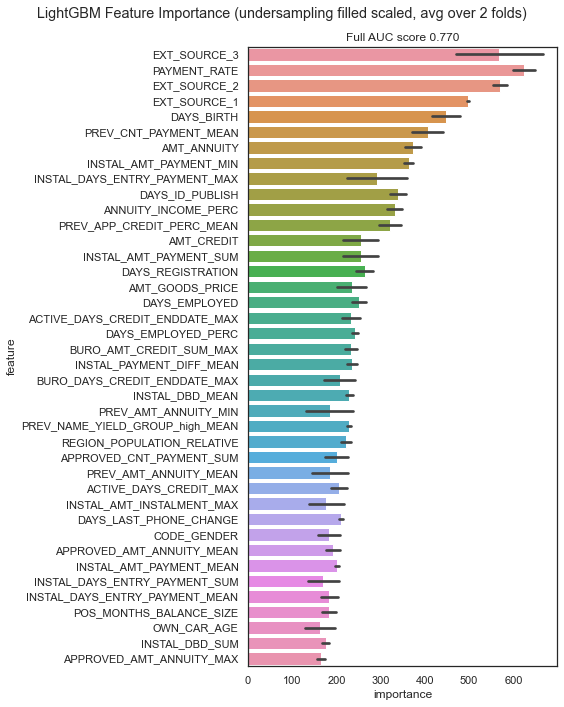

In [116]:
with timer("Run LightGBM with kfold"):
    feat_importance_lgbm3 = kfold_lightgbm(pd.concat(
        [X_scaled, y_resampled], axis=1), num_folds=2, stratified=True, debug=False)

plt.suptitle(
    'LightGBM Feature Importance (undersampling filled scaled, avg over 2 folds)')
to_png()


### Ranking de feature importance


In [117]:
def calc_rank_feature(df: pd.DataFrame, modelname='model') -> pd.DataFrame:
    ret = df.groupby(['feature'])['importance'].mean(
    ).sort_values(ascending=False).reset_index()
    ret = ret.rename_axis('rank').reset_index()
    ret['rank'] = ret['rank'].astype(int)
    ret['model'] = modelname
    return ret


lgbm1 = calc_rank_feature(feat_importance_lgbm1, 'lgbm1')
lgbm1.head()


,rank,feature,importance,model
0,0,PAYMENT_RATE,1037.0,lgbm1
1,1,EXT_SOURCE_3,917.5,lgbm1
2,2,EXT_SOURCE_1,853.5,lgbm1
3,3,EXT_SOURCE_2,850.0,lgbm1
4,4,DAYS_BIRTH,620.0,lgbm1


In [118]:
lgbm2 = calc_rank_feature(feat_importance_lgbm2, 'lgbm2')
lgbm2.head()


,rank,feature,importance,model
0,0,EXT_SOURCE_2,617.0,lgbm2
1,1,EXT_SOURCE_1,600.0,lgbm2
2,2,EXT_SOURCE_3,595.0,lgbm2
3,3,PAYMENT_RATE,548.5,lgbm2
4,4,PREV_CNT_PAYMENT_MEAN,408.0,lgbm2


In [119]:
lgbm3 = calc_rank_feature(feat_importance_lgbm3, 'lgbm3')
lgbm3.head()


,rank,feature,importance,model
0,0,PAYMENT_RATE,624.0,lgbm3
1,1,EXT_SOURCE_2,570.5,lgbm3
2,2,EXT_SOURCE_3,568.0,lgbm3
3,3,EXT_SOURCE_1,497.0,lgbm3
4,4,DAYS_BIRTH,448.0,lgbm3


Créer un dataframe pour enregistre le ranking de feature importance


In [120]:
df_feature_rank = pd.DataFrame(
    [], columns=['model', 'feature', 'importance', 'rank'])
df_feature_rank['rank'] = df_feature_rank['rank'].astype(int)
df_feature_rank = df_feature_rank.append(lgbm2).append(lgbm3)
# df_feature_rank= df_feature_rank.append(lgbm2)
df_feature_rank.head()


,model,feature,importance,rank
0,lgbm2,EXT_SOURCE_2,617.0,0
1,lgbm2,EXT_SOURCE_1,600.0,1
2,lgbm2,EXT_SOURCE_3,595.0,2
3,lgbm2,PAYMENT_RATE,548.5,3
4,lgbm2,PREV_CNT_PAYMENT_MEAN,408.0,4


In [122]:
# df_feature_rank.groupby('feature').agg({'rank':'mean'}).sort_values(by='rank')
df_feature_rank.groupby('feature').mean().sort_values(by='rank')


,importance,rank
feature,,
EXT_SOURCE_2,593.75,0.5
PAYMENT_RATE,586.25,1.5
EXT_SOURCE_3,581.50,2.0
EXT_SOURCE_1,548.50,2.0
PREV_CNT_PAYMENT_MEAN,407.00,4.5
DAYS_BIRTH,413.00,4.5
INSTAL_AMT_PAYMENT_MIN,352.00,6.5
AMT_ANNUITY,340.00,7.0
DAYS_ID_PUBLISH,329.00,7.5


In [123]:
def top_ranked_features(df: pd.DataFrame, nb=40) -> list:
    ranked = df.groupby('feature').mean().sort_values(by='rank')
    nb = min(nb, len(ranked))
    return ranked.index[:nb]


top_features = top_ranked_features(df_feature_rank)
print(list(top_features))


['EXT_SOURCE_2', 'PAYMENT_RATE', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'PREV_CNT_PAYMENT_MEAN', 'DAYS_BIRTH', 'INSTAL_AMT_PAYMENT_MIN', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'PREV_APP_CREDIT_PERC_MEAN', 'ANNUITY_INCOME_PERC', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'INSTAL_AMT_PAYMENT_SUM', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_SUM_MAX', 'INSTAL_DBD_MEAN', 'DAYS_REGISTRATION', 'INSTAL_PAYMENT_DIFF_MEAN', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'PREV_NAME_YIELD_GROUP_high_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'PREV_AMT_ANNUITY_MIN', 'POS_MONTHS_BALANCE_SIZE', 'APPROVED_CNT_PAYMENT_SUM', 'INSTAL_AMT_PAYMENT_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'INSTAL_AMT_INSTALMENT_MAX', 'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE', 'APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_AMT_ANNUITY_MAX', 'CODE_GENDER', 'CLOSED_AMT_CREDIT_SUM_MAX', 'INSTAL_DBD_SUM', 'BURO_DAYS_CREDIT_MAX']


In [124]:
def bottom_ranked_features(df: pd.DataFrame, nb=20) -> list:
    ranked = df.groupby('feature').mean().sort_values(by='rank')
    nb = min(nb, len(ranked))
    return ranked.index[-nb:]


bottom_features = bottom_ranked_features(df_feature_rank, nb=40)
print(list(bottom_features))


['APPROVED_DAYS_DECISION_MIN', 'CLOSED_DAYS_CREDIT_MIN', 'PREV_DAYS_DECISION_MIN', 'PREV_NAME_PRODUCT_TYPE_walkin_MEAN', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MIN', 'PREV_PRODUCT_COMBINATION_Cash_XSell_low_MEAN', 'NAME_INCOME_TYPE_Working', 'FLAG_DOCUMENT_3', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 'DEF_60_CNT_SOCIAL_CIRCLE', 'PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN', 'PREV_CODE_REJECT_REASON_HC_MEAN', 'NAME_EDUCATION_TYPE_Secondary_secondary_special', 'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE_Higher_education', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'BURO_CREDIT_TYPE_Mortgage_MEAN', 'NAME_CONTRACT_TYPE_Revolving_loans', 'BURO_CREDIT_TYPE_Microloan_MEAN', 'PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN', 'PREV_NAME_PORTFOLIO_Cards_MEAN', 'PREV_NAME_GOODS_CATEGORY_Furniture_MEAN', 'WALLSMATERIAL_MODE_Panel', 'PREV_CHANNEL_TYPE_AP_Cash_loan_MEAN', 'PREV_PRODUCT_COMBINATION_Cash_XSell_high_MEAN', 'PREV_PRODUCT_COMBINATION_Card_Street_MEAN', 'EMERGENCY

### Conclusion

- Les 5 best features domine le feature importance, quoi qui soit le strategy de sampling.
- Les dernieres 10 variables ont aucun feature importance, quoi qui soit le strategy de sampling

On peut conclure que les 100 best features sont probablement suffisant pour la modélisation.

## Filter features based on correlation

800 colonnes ralenti la modélisation.

Dans une prémier temps, on élimine les colonnes avec un très bas corrélation avec le target

Pour calculer un valeur de corrélation entre -1 et +1:

- il faut qu'il n'y a pas de NaN (dropna pendant le calcul)
- il faut plus d'un valeur (sinon, correlation = NaN)
- il faut qu'il n'y a pas des valeurs infinit


In [101]:
def target_correlations(df, target_col='TARGET', exclude_cols=['SK_ID_CURR']):
    """Find correlations with the target and sort"""
    if len(exclude_cols) > 0:
        df = df.drop(columns=exclude_cols)
    res = pd.DataFrame()
    for col in df.columns:
        if col != target_col:
            data = df[[col, target_col]].dropna()
            corrln = data[col].corr(data[target_col])
            res = res.append(
                {'col': col, 'correlation': corrln}, ignore_index=True)
    return res.sort_values(by='correlation', ascending=False)


with timer(title='Calculating correlations'):
    correlations = target_correlations(df_data)

# Display correlations
print('Most Positive Correlations:\n', correlations.head(15))
print('\nMost Negative Correlations:\n', correlations.tail(15))


Calculating correlations - done in 4s
Most Positive Correlations:
                                        col  correlation
10                   BURO_DAYS_CREDIT_MEAN     0.089730
8                               DAYS_BIRTH     0.078242
48  PREV_NAME_CONTRACT_STATUS_Refused_MEAN     0.077681
33          BURO_CREDIT_ACTIVE_Active_MEAN     0.077357
31                    BURO_DAYS_CREDIT_MIN     0.075248
7                            DAYS_EMPLOYED     0.074956
82            BURO_DAYS_CREDIT_UPDATE_MEAN     0.068928
14                 ACTIVE_DAYS_CREDIT_MEAN     0.064040
9                   CLOSED_DAYS_CREDIT_MIN     0.061194
16             REGION_RATING_CLIENT_W_CITY     0.060895
37                  ACTIVE_DAYS_CREDIT_MAX     0.060414
40                    REGION_RATING_CLIENT     0.058901
78                 CLOSED_DAYS_CREDIT_MEAN     0.058492
60                NAME_INCOME_TYPE_Working     0.057483
44      PREV_NAME_PRODUCT_TYPE_walkin_MEAN     0.057411

Most Negative Correlations:
        

On ajout une colonne avec la valeur absolute de correlation


In [102]:
correlations['abs_corr'] = np.abs(correlations['correlation'])
